In [1]:
#%pip install msticpy\[all] --upgrade
#%pip install msticpy --upgrade

In [2]:
import msticpy as mp
print(mp.__version__)
print(mp.__path__)
mp.init_notebook()


2.16.2
['/Users/hacket/opt/anaconda3/envs/msticpy/lib/python3.9/site-packages/msticpy']


In [ ]:
# check the splunk version via REST API
!curl https://localhost:8089 -k

In [4]:
splunk_token_prov = mp.QueryProvider("Splunk")
splunk_token_prov.connect()

Credential loading from msticpyconfig.yaml file.
bearer_token method is selected.
This bearer_token is active until 2026-04-07 07:29:40+00:00
Connected.


In [5]:
spl_query = 'search timeformat="%Y-%m-%d %H:%M:%S" earliest="2017-08-01 09:00:00" latest="2017-09-01 08:00:00" \
index=botsv2 sourcetype=suricata event_type=flow app_proto=dns \
| timechart span=1h count dc(src_ip) dc(dest_ip) sum(flow.bytes_toclient) sum(flow.bytes_toserver) sum(flow.pkts_toclient) sum(flow.pkts_toserver)'
base_df = splunk_token_prov.exec_query(spl_query)
base_df.head()

Waiting Splunk job to complete: 715.299it [00:12, 58.60it/s]                       
Waiting Splunk result to retrieve: 1543it [00:00, 18169.65it/s]           


,_time,count,dc(src_ip),dc(dest_ip),sum(flow.bytes_toclient),sum(flow.bytes_toserver),sum(flow.pkts_toclient),sum(flow.pkts_toserver),_span
0,2017-08-01T09:00:00.000+09:00,94,10,3,54022,26278,306,310,3600
1,2017-08-01T10:00:00.000+09:00,127,9,4,69058,49070,408,438,3600
2,2017-08-01T11:00:00.000+09:00,108,8,4,60850,45198,364,388,3600
3,2017-08-01T12:00:00.000+09:00,120,10,2,75028,47204,408,418,3600
4,2017-08-01T13:00:00.000+09:00,112,10,2,63054,33154,360,392,3600


# Target anomaly range of DNS C2 beacon in Splunk BOTS v2 data

## DGA spike

timeformat="%Y-%m-%d %H:%M:%S" earliest="2017-08-26 16:00:00" latest="2017-08-26 17:00:00" index=botsv2 sourcetype=stream:dns 
| spath "query{}"
| eval dga = if(LIKE('query{}',"%.hildegardsfarm.com"),1,null())
| stats count count(dga) by src_ip

## 2nd big spike

timeformat="%Y-%m-%d %H:%M:%S" earliest="2017-08-24 12:00:00" latest="2017-08-24 14:00:00"  index=botsv2 sourcetype=stream:dns
```| stats count by src_ip,dest_ip,message_type{}```
| stats count dc(src_ip) dc(dest_ip) by query{}

# Using Isolation Forest with default outlier module

In [6]:
# Pre Processing 
import re
import pandas as pd

def replace_column_name(column_name):
    column_name = re.sub(r'\((.*?)\)', lambda m: '_' + m.group(1), column_name)
    column_name = column_name.replace('.', '_')
    return column_name

if_df = base_df.copy()

if_df.set_index("_time", inplace=True)
if_df.fillna(0, inplace=True)
for col in if_df.columns:
    if_df[col] = if_df[col].astype(float)

if_df = if_df.drop("_span",axis=1)

new_columns = if_df.columns.map(replace_column_name)
if_df.columns = new_columns
print(if_df.columns)

if_df.head()


Index(['count', 'dc_src_ip', 'dc_dest_ip', 'sum_flow_bytes_toclient',
       'sum_flow_bytes_toserver', 'sum_flow_pkts_toclient',
       'sum_flow_pkts_toserver'],
      dtype='object')


,count,dc_src_ip,dc_dest_ip,sum_flow_bytes_toclient,sum_flow_bytes_toserver,sum_flow_pkts_toclient,sum_flow_pkts_toserver
_time,,,,,,,
2017-08-01T09:00:00.000+09:00,94.0,10.0,3.0,54022.0,26278.0,306.0,310.0
2017-08-01T10:00:00.000+09:00,127.0,9.0,4.0,69058.0,49070.0,408.0,438.0
2017-08-01T11:00:00.000+09:00,108.0,8.0,4.0,60850.0,45198.0,364.0,388.0
2017-08-01T12:00:00.000+09:00,120.0,10.0,2.0,75028.0,47204.0,408.0,418.0
2017-08-01T13:00:00.000+09:00,112.0,10.0,2.0,63054.0,33154.0,360.0,392.0


In [7]:
from msticpy.analysis.outliers import identify_outliers

# Feature selection
feature_columns = if_df.columns.tolist()
print("Selected features:", feature_columns)
print("Number of features:", len(feature_columns))

#feature_columns = ['count','dc_src_ip']
feature_columns = ['count', 'dc_src_ip', 'dc_dest_ip', 'sum_flow_bytes_toclient', 'sum_flow_bytes_toserver', 'sum_flow_pkts_toclient', 'sum_flow_pkts_toserver']
X = if_df[feature_columns].values

# Check the shape of X
print("Shape of X:", X.shape)

# Perform anomaly detection
clf, X_outliers, y_pred_outliers = identify_outliers(X, X, contamination=0.01, max_features=X.shape[1], max_samples=X.shape[0])

# Add outlier flag to the original DataFrame
if_df['outlier'] = y_pred_outliers

# Display detected outliers
print("Detected outliers:")
display(if_df[if_df['outlier'] == -1])

# Display statistics of outliers
print("\nOutlier statistics:")
print(if_df['outlier'].value_counts())

# Display feature-wise statistics for normal and outlier data
print("\nFeature statistics for normal and outlier data:")
for feature in feature_columns:
    print(f"\n{feature}:")
    print(if_df.groupby('outlier')[feature].describe())


Selected features: ['count', 'dc_src_ip', 'dc_dest_ip', 'sum_flow_bytes_toclient', 'sum_flow_bytes_toserver', 'sum_flow_pkts_toclient', 'sum_flow_pkts_toserver']
Number of features: 7
Shape of X: (743, 7)
Detected outliers:


,count,dc_src_ip,dc_dest_ip,sum_flow_bytes_toclient,sum_flow_bytes_toserver,sum_flow_pkts_toclient,sum_flow_pkts_toserver,outlier
_time,,,,,,,,
2017-08-11T12:00:00.000+09:00,190.0,13.0,2.0,119734.0,66236.0,628.0,638.0,-1
2017-08-19T06:00:00.000+09:00,1019.0,15.0,12.0,483774.0,288742.0,2778.0,2978.0,-1
2017-08-24T12:00:00.000+09:00,2312.0,15.0,10.0,1162924.0,648262.0,7240.0,7360.0,-1
2017-08-24T13:00:00.000+09:00,2614.0,14.0,15.0,1408692.0,759247.0,8564.0,8836.0,-1
2017-08-26T15:00:00.000+09:00,2912.0,15.0,7.0,731600.0,704315.0,4080.0,7279.0,-1
2017-08-26T16:00:00.000+09:00,16099.0,15.0,10.0,8039630.0,5863068.0,46066.0,56676.0,-1
2017-08-26T17:00:00.000+09:00,5302.0,14.0,8.0,3173250.0,2096488.0,18219.0,20087.0,-1
2017-08-29T19:00:00.000+09:00,1243.0,15.0,7.0,747622.0,397776.0,4400.0,4518.0,-1



Outlier statistics:
 1    735
-1      8
Name: outlier, dtype: int64

Feature statistics for normal and outlier data:

count:
         count         mean          std    min     25%     50%     75%  \
outlier                                                                   
-1         8.0  3961.375000  5141.243094  190.0  1187.0  2463.0  3509.5   
 1       735.0   301.922449   184.286460    0.0   121.0   324.0   454.0   

             max  
outlier           
-1       16099.0  
 1        1008.0  

dc_src_ip:
         count       mean       std   min   25%   50%   75%   max
outlier                                                          
-1         8.0  14.500000  0.755929  13.0  14.0  15.0  15.0  15.0
 1       735.0  10.598639  2.406451   0.0  10.0  11.0  12.0  15.0

dc_dest_ip:
         count      mean       std  min  25%  50%   75%   max
outlier                                                      
-1         8.0  8.875000  3.870677  2.0  7.0  9.0  10.5  15.0
 1       735.0  3.9700

In [8]:
## Time Series Graph
from msticpy.nbtools.timeseries import display_timeseries_anomolies

output = if_df.copy()

# When using the display_timeseries_anomolies function, apply the datetime type to the time field of the result and sort it in chronological order in advance.
if_df['date_clock'] = pd.to_datetime(if_df.index)
if_df = if_df.sort_values(by='date_clock')
if_df['baseline'] = if_df['count']

# If the outlier column is -1, set the abnormal column to 1, otherwise set it to 0
if_df['anomalies'] = (if_df['outlier'] == -1).astype(int)

timeseries_anomalies_plot = display_timeseries_anomolies(
    data=if_df, 
    y='count',
    time_column='date_clock'
    )



Loading BokehJS ...

2025-04-24 00:30:58,987: ERROR - E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : y='score' [no close matches] {renderer: GlyphRenderer(id='p1179', ...)} (check#210)


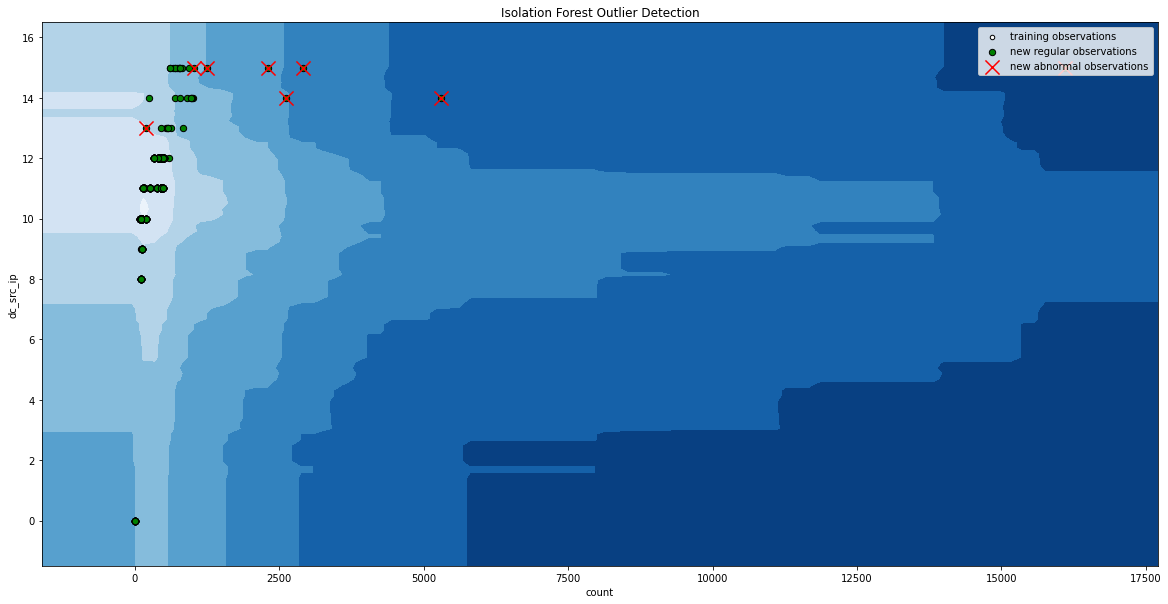

In [9]:

from msticpy.analysis.outliers import plot_outlier_results

feature_columns = ['count','dc_src_ip']

# Plot the result  
plot_outlier_results(clf, X, X, X_outliers, feature_columns=feature_columns, plt_title="Isolation Forest Outlier Detection")



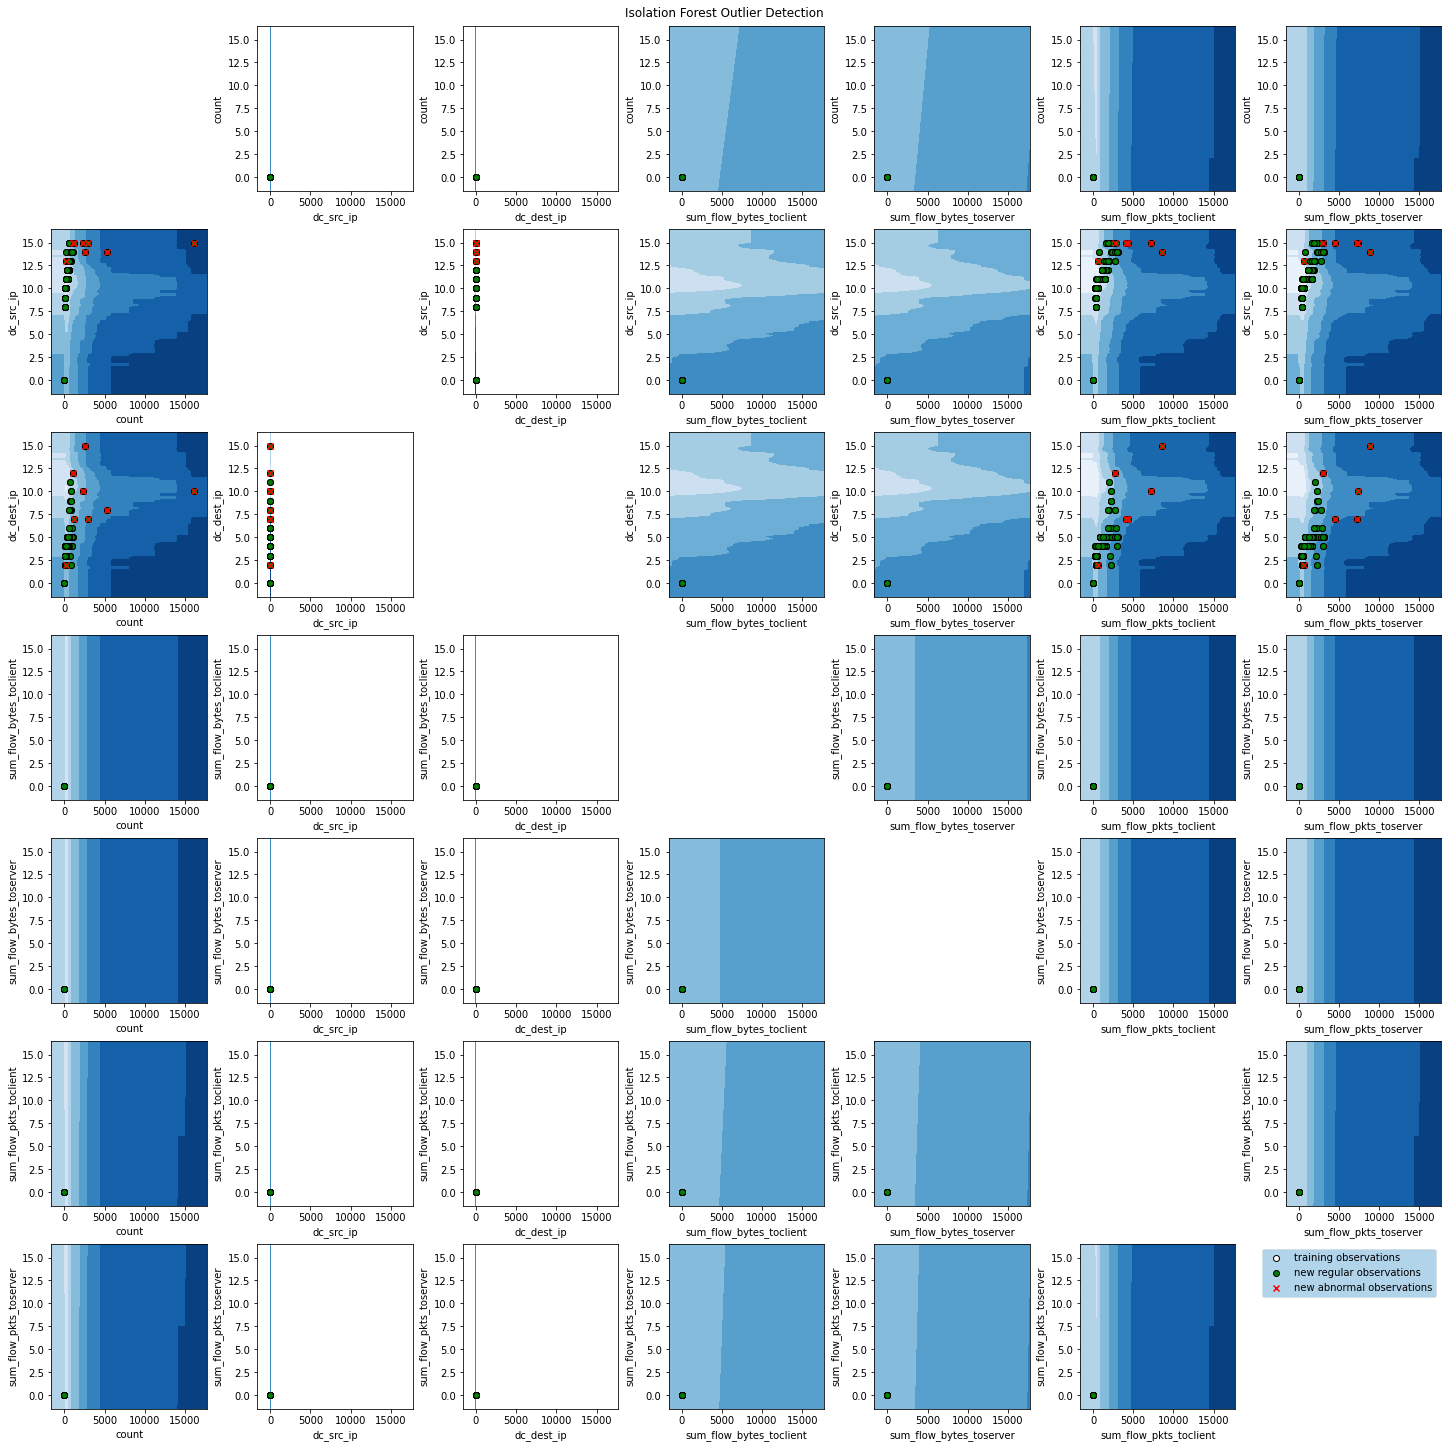

In [11]:

from msticpy.analysis.outliers import plot_outlier_results

feature_columns = ['count', 'dc_src_ip', 'dc_dest_ip', 'sum_flow_bytes_toclient', 'sum_flow_bytes_toserver', 'sum_flow_pkts_toclient', 'sum_flow_pkts_toserver']

# Plot the multi dimentional grid result
plot_outlier_results(clf, X, X, X_outliers, feature_columns=feature_columns, plt_title="Isolation Forest Outlier Detection")
